# Key Developments Events

Concepts:

## Event Studies, Cumulative Abnormal Returns (CAR)                                                             
## NLP, Supervised Learning, Text Classification

Author: Terence Lim

References:

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import pickle
from pprint import pprint
import sklearn, sklearn.feature_extraction
import dives
from dives.util import DataFrame, wordcloud_features
from dives.dbengines import SQL, Redis, MongoDB
from dives.structured import BusDates, Benchmarks, CRSP, PSTAT
from dives.unstructured import Unstructured
from dives.custom import CustomTokenizer, CustomClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import secret    # passwords etc                                                                             
sql = SQL(**secret.value('sql'))
rdb = Redis(**secret.value('redis'))
mongodb = MongoDB(**secret.value('mongodb'))
bd = BusDates(sql)
bench = Benchmarks(sql, bd)
crsp = CRSP(sql, bd, rdb)
keydev = PSTAT(sql, bd)
outdir = secret.value('events')['dir']


### helper function to extract announcement window and calculate event-time cumulative abnormal returns
Only a simple market adjustment applied -- may want to consider using estimated stock betas and/or other benchmarks

In [20]:
def event_study(keydev, eventid, roleid=None, beg=19890701, end=20190630, outdir='', minobs=500):
    """helper function to execute event study for list of events by id                                       
                                                                                                             
    Parameters                                                                                               
    ----------                                                                                               
    keydev : PSTAT instance                                                                                  
        connection to keydev database                                                                        
    eventid : int                                                                                            
        event id                                                                                             
    roleid : int, optional (default None)                                                                    
        role id.  None for all roles                                                                         
    beg : int, optional                                                                                      
        earliest announcement date                                                                           
    end : int, optional                                                                                      
        latest announcement date                                                                             
    outdir : string, optional (default '')                                                                   
        directory in which to store jpg and html results.  None or blank to display only.                    
    minobs : int, optional (default 500)                                                                     
        minimum sample size                                                                                  
    """

    # query keydev database, link to crsp permnos                                                            
    numobs = 0
    role = " and keydevtoobjectroletypeid = {} ".format(roleid) if roleid else ""
    event = " and keydeveventtypeid = {} ".format(eventid)
    df = keydev.get_linked(table = 'keydev',
                           date_field = 'announcedate',
                           fields=['companyname',
                                   'keydevid',
                                   'keydeveventtypeid',
                                   'keydevtoobjectroletypeid'],
                           where = ('announcedate >= {beg} ' \
                                    ' and announcedate <= {end} {event} {role}'\
                                    ''.format(beg = beg,
                                              end = end,
                                              event = event,
                                              role = role)))
    if len(df) > minobs:  # minimum sample size                                                              
        # get stock and market returns within {left} and {right} window around announcedate                  
        left = -1
        right = 21
        rets = crsp.get_window('daily', 'ret', df['permno'],     # get stock returns for permnos             
                               df['announcedate'], left, right)  #   around announcement date                
        mkt = bench.get_window('daily', 'ret', ['Mkt-RF'] * len(df),
                               df['announcedate'], left, right)  # and market returns                        
        rf = bench.get_window('daily', 'ret', ['RF'] * len(df),
                              df['announcedate'], left, right)   # and risk free-returns                     
        cols = ['day' + str(d) for d in range(right-left+1)]

        # Subtract market returns (could consider beta-adjust or other suitable benchmarks)                  
        rets[cols] = rets[cols] - (mkt[cols] + rf[cols])
        rets = rets.loc[rets[cols].isnull().sum(axis=1).eq(0)]  # require full window (biased)               
        cumrets = (1+rets[cols]).cumprod(axis=1)                # construct cumulative returns               

        # Split sample by market cap (large, small) and sample period (first, second half)                   
        cap = crsp.get_many('daily',          # query crsp for market cap (prc*shrout) of permnos            
                            rets['permno'],
                            rets['date'],
                            ['prc', 'shrout'])
        cumrets['cap'] = list(cap['prc'].abs() * cap['shrout'])
        cumrets['date'] = list(rets['date'])
        cumrets = cumrets[cumrets['cap'].ge(300000)]   # drop microcaps < $300 million                       
        lo, mid, hi = np.percentile(cumrets['date'], [0,50,100])  # to halve sample period                   
        before = cumrets['date'].le(mid)
        small = cumrets['cap'].lt(2000000)             # split large/small cap at $2 billion                 
        cumrets.loc[~small & ~before, 'sub'] = 'Large ({:.0f}-{:.0f})'.format(mid, hi)
        cumrets.loc[small & ~before, 'sub'] = 'Small ({:.0f}-{:.0f})'.format(mid, hi)
        cumrets.loc[~small & before, 'sub'] = 'Large ({:.0f}-{:.0f}]'.format(lo, mid)
        cumrets.loc[small & before, 'sub'] = 'Small ({:.0f}-{:.0f}]'.format(lo, mid)
        numobs += len(cumrets)
        # average stocks' cumulative abnormal returns and compute stderrs.  display and plot                 
        plt.figure(figsize=(10,6))
        plt.clf()
        ax = plt.subplot(2,2,1)    # to share axes
        for iplot, sub in enumerate(np.unique(cumrets['sub'])):

            # Combine stocks with same announcement date -- lest correlated cross-sectional errors           
            excess = cumrets[cumrets['sub'] == sub].drop(columns='cap').groupby('date').mean()

            # Compute event-window daily average cumulative returns                                          
            mean = excess.mean()                          # mean cumulative return of each day               
            stderr = excess.std()/np.sqrt(len(excess))    # cross-sectional stdeerr                          
            tstat = (mean[1 - left] - 1)/stderr[1 - left] # tstat of third day's cumulative return           

            post = excess.iloc[:,-1] / excess.iloc[:, 1-left]         # post-announcement drift              
            post = (post.mean()-1) / (post.std()/np.sqrt(len(post)))  # t-stat of average drift              

            s = " (%d) %s" % (roleid, keydev.role[roleid]) if roleid else ''
            print("[(%d) %s %s] n=%5d, tstat: %6.2f,  post: %6.2f, %s" %
                  (eventid, keydev.event[eventid], s, len(excess), tstat, post, sub))


            # Plot mean cumulative returns, and 2-stderr bands                                               
            plt.subplot(2, 2, iplot+1, sharex=ax, sharey=ax)  # sharex and sharey
            x = np.arange(left, right+1)                      # x-axis is event day number                       
            plt.plot(x, mean, 'b-')
            plt.fill_between(x, mean - (2 * stderr), mean + (2 * stderr), alpha = 0.3)
            plt.legend(['excess', '+/- 2 stderr'])
            plt.axhline(1, linestyle=':', color='y')
            plt.axvline(1, linestyle=':', color='y')
            plt.title ("{event} ({id}) {role}" \
                       "".format(event = keydev.event[eventid],
                                 id = eventid,
                                 role =keydev.role[roleid] if roleid else ''),
                       fontsize = 'small')
            plt.ylabel("%s [n=%d]" % (sub, len(excess)), fontsize = 'small')
            
            if outdir:   # to save jpg and html
                with open(outdir + 'index.html', 'at') as f:
                    f.write("<pre>\n")
                    s = " (%d) %s" % (roleid, keydev.role[roleid]) if roleid else ''
                    f.write("(%d) %s %s n=%5d,  tstat: %6.2f, post: %6.2f,  %s\n" %
                            (eventid, keydev.event[eventid], s, len(excess), tstat, post, sub))
                    f.write("</pre>\n")
        if outdir:
            savefig = outdir + "{}_{}.jpg".format(eventid, roleid if roleid else '')
            with open(outdir + 'index.html', 'at') as f:
                f.write('<img src="{}"><hr><p>\n'.format(savefig))
            plt.savefig(savefig)
    return numobs

### Average cumulative abnormal returns (CAR) for some events: 
Compare announcement-window vs post-announcement-drift

[(101) Executive Changes - CEO  (1) Target] n= 1112, tstat:  -0.45,  post:  -0.77, Large (20000515-20100802]
[(101) Executive Changes - CEO  (1) Target] n= 1264, tstat:  -2.40,  post:  -1.88, Large (20100802-20190530)
[(101) Executive Changes - CEO  (1) Target] n= 1434, tstat:  -0.25,  post:  -0.56, Small (20000515-20100802]
[(101) Executive Changes - CEO  (1) Target] n= 1316, tstat:  -3.96,  post:  -4.81, Small (20100802-20190530)
8429 obs for event 101. Executive Changes - CEO


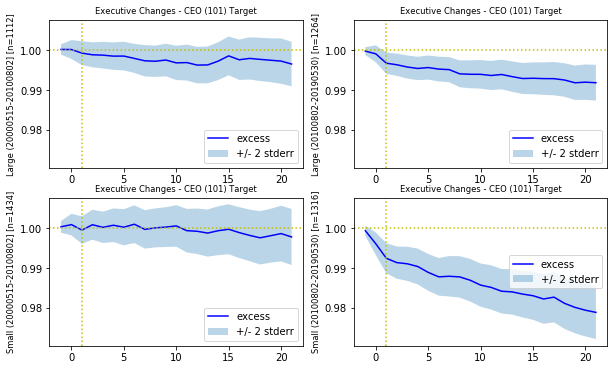

[(192) Analyst/Investor Day  (1) Target] n=  888, tstat:   3.26,  post:   2.59, Large (20040413-20140310]
[(192) Analyst/Investor Day  (1) Target] n=  815, tstat:   1.56,  post:   2.26, Large (20140310-20190529)
[(192) Analyst/Investor Day  (1) Target] n=  801, tstat:   2.65,  post:   2.29, Small (20040413-20140310]
[(192) Analyst/Investor Day  (1) Target] n=  567, tstat:   2.11,  post:   0.49, Small (20140310-20190529)
4866 obs for event 192. Analyst/Investor Day


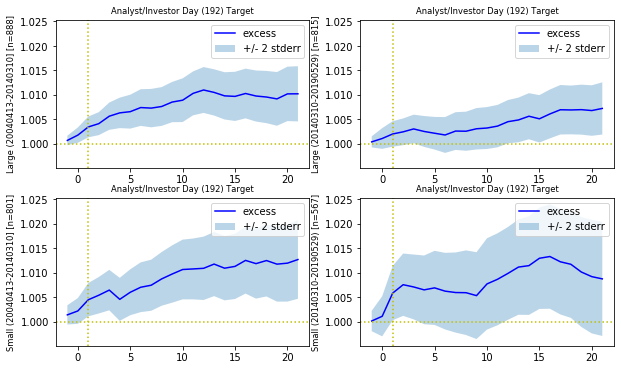

[(65) M&A Rumors and Discussions  (1) Target] n= 1791, tstat:   6.98,  post:   0.38, Large (19900809-20120801]
[(65) M&A Rumors and Discussions  (1) Target] n= 1680, tstat:   9.71,  post:  -2.17, Large (20120801-20190530)
[(65) M&A Rumors and Discussions  (1) Target] n= 1567, tstat:   8.04,  post:   2.80, Small (19900809-20120801]
[(65) M&A Rumors and Discussions  (1) Target] n= 1289, tstat:   9.35,  post:  -2.53, Small (20120801-20190530)
29839 obs for event  65. M&A Rumors and Discussions


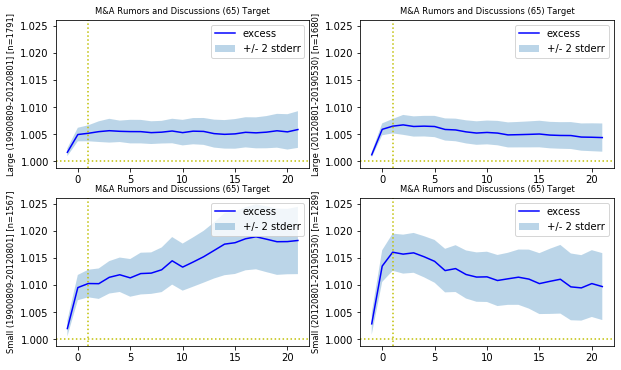

[(80) M&A Transaction Announcements  (1) Target] n=  438, tstat:  17.63,  post:  -1.60, Large (19890703-20070323]
[(80) M&A Transaction Announcements  (1) Target] n=  597, tstat:  21.77,  post:  -1.41, Large (20070323-20190528)
[(80) M&A Transaction Announcements  (1) Target] n= 1072, tstat:  31.60,  post:   0.25, Small (19890703-20070323]
[(80) M&A Transaction Announcements  (1) Target] n=  948, tstat:  25.34,  post:  -0.74, Small (20070323-20190528)
3861 obs for event  80. M&A Transaction Announcements


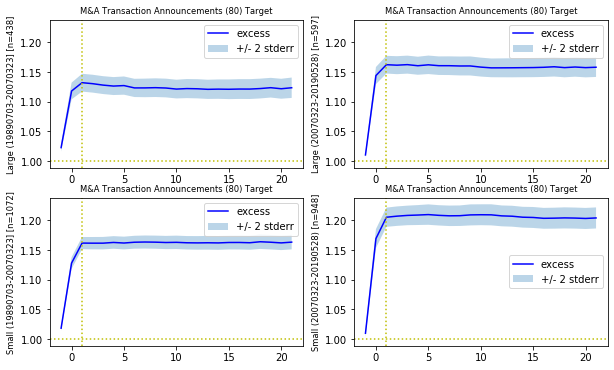

[(26) Corporate Guidance - Lowered  (1) Target] n=  858, tstat: -16.54,  post:  -0.34, Large (20011212-20090728]
[(26) Corporate Guidance - Lowered  (1) Target] n= 1001, tstat: -14.84,  post:   1.01, Large (20090728-20190523)
[(26) Corporate Guidance - Lowered  (1) Target] n= 1098, tstat: -26.76,  post:  -0.73, Small (20011212-20090728]
[(26) Corporate Guidance - Lowered  (1) Target] n=  892, tstat: -20.41,  post:  -1.00, Small (20090728-20190523)
7483 obs for event  26. Corporate Guidance - Lowered


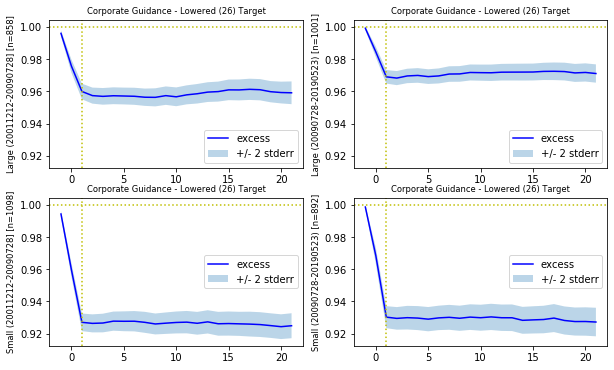

[(27) Corporate Guidance - Raised  (1) Target] n= 1285, tstat:  18.25,  post:   1.42, Large (20011217-20100726]
[(27) Corporate Guidance - Raised  (1) Target] n= 1216, tstat:  11.93,  post:   1.62, Large (20100726-20190530)
[(27) Corporate Guidance - Raised  (1) Target] n= 1373, tstat:  21.27,  post:   3.78, Small (20011217-20100726]
[(27) Corporate Guidance - Raised  (1) Target] n= 1076, tstat:  17.04,  post:  -0.94, Small (20100726-20190530)
15423 obs for event  27. Corporate Guidance - Raised


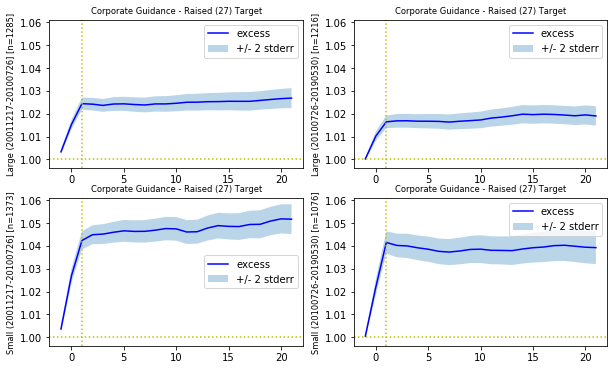

[(86) Follow-on Equity Offerings  (1) Target] n= 1431, tstat:  -8.08,  post:   2.33, Large (19911107-20090812]
[(86) Follow-on Equity Offerings  (1) Target] n= 1449, tstat: -14.71,  post:  -0.10, Large (20090812-20190530)
[(86) Follow-on Equity Offerings  (1) Target] n= 2556, tstat: -10.67,  post:   1.81, Small (19911107-20090812]
[(86) Follow-on Equity Offerings  (1) Target] n= 1955, tstat: -14.59,  post:   0.04, Small (20090812-20190530)
18491 obs for event  86. Follow-on Equity Offerings


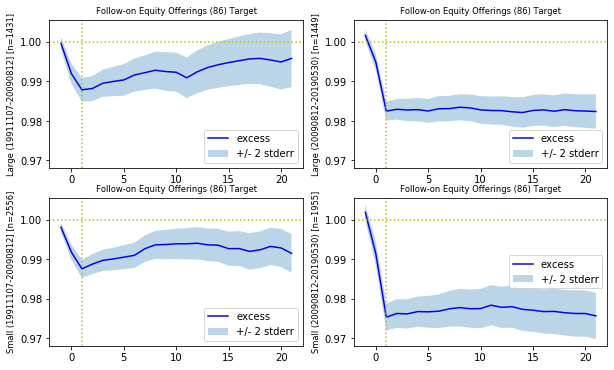

In [21]:
    events = [101, 192, 65, 80, 26, 27, 86]
    role = 1
    for event in events:
        n = event_study(keydev, event, role, outdir = None)
        print('{:4d} obs for event {:3d}. {}'.format(n, event, keydev.event[event]))
        plt.show()


### Run event_study for all events and roles
see output at [https://terence-lim.github.io/events](https://terence-lim.github.io/events)

In [ ]:
    %matplotlib agg;
    events = keydev.event.keys()
    roles = [None] + list(keydev.role.keys())      # loop over all role-ids                                  
    with open(outdir + 'index.html', 'wt') as f:
        f.write('Event study CAR<br>')
        f.write(' tstat: is of 3-day average CAR around announcement date<br>')
        f.write(' post: is t-stat of average CAR from day+2 to day+21 (both days inclusive)<br>')
        f.write('<p>\n')
    for event in events:
        numobs, numroles = 0,0
        for role in roles:
            n = event_study(keydev, event, role, outdir = outdir)
            if n:
                plt.show()
                numobs, numroles = numobs + n, numroles + 1
    %matplotlib inline;

### Classify events from situation text using some NLP and Supervised Learning methods

In [11]:
    situations = Unstructured(mongodb, 'situations')   # unstructured text was stored in mongodb             

    # Collect all sample text into {data}, and labels (i.e. event id's) into {y_all}                         
    data = []
    y_all = np.empty((0,))
    for event in [101, 192, 65, 80, 26, 27, 86]:
        docs = situations.mongo.find({'$and': [{'keydeveventtypeid' : {'$eq' : event}},
                                               {'keydevtoobjectroletypeid' : { '$eq': 1}}]},
                                     {'_id' : 0})
        text = [re.sub(r'\b\w*[\d]\w*\b', ' ', d['situation'])   # strip out numbers                         
                for d in docs if d['situation'] and len(d['situation']) > 80]
        data = data + text
        y_all = np.append(y_all, np.repeat(event, len(text)))


### Fit some classifiers: support vector machine, logistic regression, naive-bayes, neural nets

In [12]:
    import warnings; warnings.filterwarnings("ignore")

    # Get stopwords wordlist                                                                                 
    wordlist = Unstructured(mongodb, 'wordlists')
    stopwords = wordlist.find_values('genericlong')[0]   # GenericLong stop words from LoughranMcDonald      
    stopwords = CustomTokenizer()(" ".join(stopwords))

    # Transform text data: tokenize, lower-case, stopwords, and Tfidf vectorizer                             
    max_df, min_df, max_features = 0.99, 20, 10000
    # set up vectorizer and models to fit                                                                    
    vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                 lowercase = True,
                                 stop_words = stopwords,
                                 max_df = max_df,
                                 min_df = min_df,
                                 max_features = max_features,
                                 tokenizer = CustomTokenizer()) #, token_pattern=r'\b[^\d\W]+\b')            
    X_all = vectorizer.fit_transform(data)
    feature_names = vectorizer.get_feature_names()

    # Fit the supervised learning models                                                                     
    results = []   # to store best score of each model                                                       
    for name in ['svclinearCV', 'logisticCV', 'multinomialNB', 'kerasClassifierCV']:
        clf = CustomClassifier[name]   # wrappers calculate basic autotuning and best (training) score       
        clf.fit(X_all, y_all)
        train_score = clf.score(X_all, y_all)
        print(name, clf.best_score_, train_score)
        results.append([clf.best_score_, name, clf])


svclinearCV 0.9553269112474466 0.9592737753219456
logisticCV 0.9660752473389872 0.9790173203484263
multinomialNB 0.9541979145923621 0.9584385067968829
Epoch 1/2
108947/108947 [==============================] - 6s 58us/step - loss: 0.2852 - accuracy: 0.9360
Epoch 2/2
108947/108947 [==============================] - 4s 40us/step
kerasClassifierCV 0.9636795520782471 0.9751163125038147


### Confusion matrix of best model:
- most confused about "Guidance lowered" vs "Guidance raised"
- also, note the imbalanced panel sizes

Confusion matrix for best model : logisticCV
[[ 1683  1904     0     0     0     4     0]
 [  319  6790     0     0     0     7     0]
 [    0     0 27028    11     0     0     0]
 [    0     0     3 12115     0     1     0]
 [    0     0     0     0 35159     0     0]
 [    3    23    10     0     0 22523     0]
 [    0     0     1     0     0     0  1363]]
(26, 'Corporate Guidance - Lowered')
(27, 'Corporate Guidance - Raised')
(65, 'M&A Rumors and Discussions')
(80, 'M&A Transaction Announcements')
(86, 'Follow-on Equity Offerings')
(101, 'Executive Changes - CEO')
(192, 'Analyst/Investor Day')


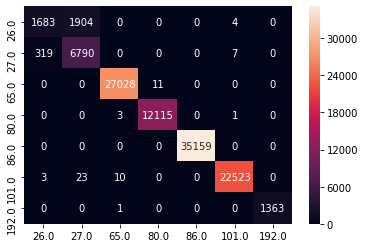

In [13]:
    name, clf = sorted(results)[-1][1:]                         # rank and get best model                    
    class_names = [keydev.event[e] for e in clf.classes_]       # lookup up class names                      
    y_pred = clf.predict(X_all)                                 # predicted labels                           
    conf_mat = sklearn.metrics.confusion_matrix(y_all, y_pred)  # display confusion matrix                   
    print('Confusion matrix for best model :', name)
    print(conf_mat)
    print("\n".join([str((int(e), keydev.event[e])) for e in clf.classes_]))
    sns.heatmap(conf_mat,                # heatmap of confusion matrix                                       
                annot = True,
                fmt = 'd',
                yticklabels = clf.classes_,
                xticklabels = clf.classes_)


### Show most important features for classifying each class

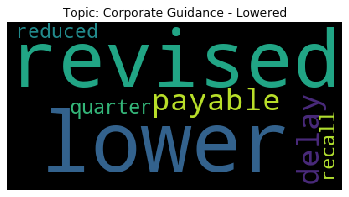

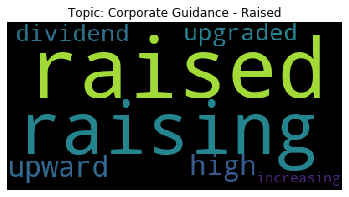

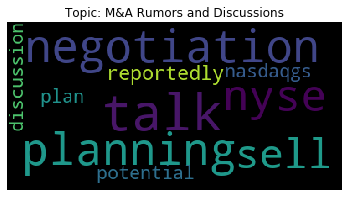

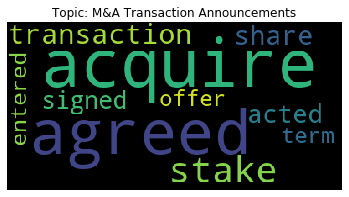

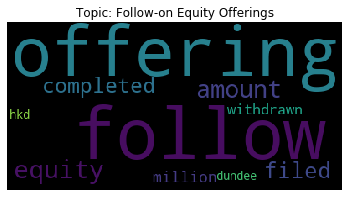

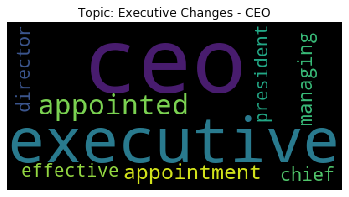

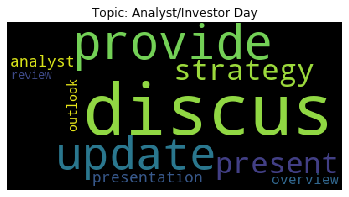

Top features for class = Corporate Guidance - Lowered
[('lower', 4.836338993952539),
 ('revised', 4.3820825072581915),
 ('payable', 4.25310058569017),
 ('delay', 4.246460716648156),
 ('quarter', 4.21796177748034),
 ('recall', 4.112904427742087),
 ('reduced', 3.8702056315201423)]
Top features for class = Corporate Guidance - Raised
[('raised', 6.870383659871975),
 ('raising', 5.0862406613435205),
 ('upward', 4.774764810738667),
 ('high', 4.367396467255715),
 ('upgraded', 4.22723324497015),
 ('dividend', 4.153214891804541),
 ('increasing', 4.0057021593855096)]
Top features for class = M&A Rumors and Discussions
[('talk', 12.599408483294402),
 ('negotiation', 10.707243992936442),
 ('planning', 10.232604413288502),
 ('nyse', 9.272325032922353),
 ('sell', 8.542657934692432),
 ('reportedly', 8.458688913215294),
 ('potential', 7.841508007947813),
 ('plan', 7.77802090347167),
 ('nasdaqgs', 7.752626477241959),
 ('discussion', 7.720169885257401)]
Top features for class = M&A Transaction Announce

In [18]:
    topics = wordcloud_features(clf.best_estimator_.coef_,  # matrix of coefficients is feature importances  
                                10,                         # number of features                             
                                feature_names,
                                class_names,
                                plot = True)
    plt.show()
    for label, features in topics.items():
        print('Top features for class =', label)
        pprint(features)


### comment